# Retraining Inception V3

In this notebook, I will go over steps to retrain Inception V3 for the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load in the Dataset

In [2]:
X_train = np.load("/floyd/input/skin_cancer_192_256/256_192_train.npy")

In [3]:
y_train = np.load("/floyd/input/skin_cancer_192_256/train_labels.npy")

In [4]:
X_val = np.load("/floyd/input/skin_cancer_192_256/256_192_val.npy")

In [5]:
y_val = np.load("/floyd/input/skin_cancer_192_256/val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load in Pretrained Inception Model

In [10]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [12]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


## Define the Model

In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 95, 127, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 95, 127, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training

Here we retrain using the whole model instead of performing transfer learning. The reason for this is the issue with batch-normalization layer implemented in Keras. During training the network will always use the mini-batch statistics either the BN layer is frozen or not; also during inference it will use the previously learned statistics of the frozen BN layers. As a result, if we fine-tune the top layers, their weights will be adjusted to the mean/variance of the new dataset. Nevertheless, during inference they will receive data which are scaled differently because the mean/variance of the original dataset will be used. Consequently, performing transfer-learning with InceptionV3 will result in very bad validation accuracy. For solution to this issue, have a look at: https://github.com/keras-team/keras/pull/9965 and https://github.com/keras-team/keras/issues/9214. For now, let's just retrain the whole model with very small learning_rate = 0.0001 and large momentum and a learning_rate_reduction function that halves the learning whenever the validation accuracy doesn't change for a 3 consecutive epochs. We will train for only 20 epochs so that the weights of the original pretrained model won't change too much and overfit the train data.

### Feature Extraction

Before we even retrain our model, it's better that we freeze all the layers in InceptionV3 and just train our top fully-connected and classification layers so that the weights for these layers won't be too random. The intuition for this is that if we didn't perform feature-extraction, then the gradient would be too large and would change the pretrained weights too much.

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
126/126 [==============================] - 90s 712ms/step - loss: 1.5553 - acc: 0.6029 - val_loss: 1.5893 - val_acc: 0.6719
Epoch 2/3
126/126 [==============================] - 83s 662ms/step - loss: 1.0996 - acc: 0.6609 - val_loss: 1.7558 - val_acc: 0.6562
Epoch 3/3
126/126 [==============================] - 85s 673ms/step - loss: 1.0364 - acc: 0.6737 - val_loss: 1.7136 - val_acc: 0.6706


### Retraining

Now, we are retraining the whole models. The goal is to just tune the weights a bit for our dataset and avoid changing the pretrained weights too much!

In [19]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [20]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 95, 127, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 95, 127, 32)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [23]:
batch_size = 64
epochs = 20
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/20
126/126 [==============================] - 168s 1s/step - loss: 0.8607 - acc: 0.7015 - val_loss: 0.7481 - val_acc: 0.7165
Epoch 2/20
126/126 [==============================] - 150s 1s/step - loss: 0.6642 - acc: 0.7636 - val_loss: 0.5757 - val_acc: 0.7969
Epoch 3/20
126/126 [==============================] - 148s 1s/step - loss: 0.5690 - acc: 0.7949 - val_loss: 0.5249 - val_acc: 0.8057
Epoch 4/20
126/126 [==============================] - 148s 1s/step - loss: 0.4897 - acc: 0.8233 - val_loss: 0.6070 - val_acc: 0.7879
Epoch 5/20
126/126 [==============================] - 148s 1s/step - loss: 0.4337 - acc: 0.8484 - val_loss: 0.6431 - val_acc: 0.7844
Epoch 6/20
126/126 [==============================] - 148s 1s/step - loss: 0.3747 - acc: 0.8647 - val_loss: 0.5480 - val_acc: 0.8326
Epoch 7/20
126/126 [==============================] - 148s 1s/step - loss: 0.3477 - acc: 0.8775 - val_loss: 0.5732 - val_acc: 0.8246
Epoch 8/20
126/126 [==============================] - 148s 1s/step - 

In [24]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 5s 6ms/step
Validation: accuracy = 0.869180  ;  loss_v = 0.517105


Even though this model overfits the training data, we also observe some significant improvement with the validation accuracy. Our final validation accuracy is 86.9%, a nearly 10% improvement from the baseline model, which justifies some more training time. We can also see that this model is extremely "sensitive", a small change in learning rate can can change the model by a whole lot. Future work on choosing learning rate as well as monitor learning rate is needed for further improvement. 

## Testing

Let's load in the intact test set and test our model

In [25]:
X_test = np.load("/floyd/input/skin_cancer_192_256/256_192_test.npy")

In [26]:
y_test = np.load("/floyd/input/skin_cancer_192_256/test_labels.npy")
y_test = to_categorical(y_test)

In [27]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 6s 6ms/step
Test: accuracy = 0.868263  ;  loss = 0.624153


Achieving test accuracy of 86.8% after 20 training epochs is a good result! This experiment proved that the architecture and the weights of Inception trained on ImageNet help learning for a complete different domain dataset. 

In [30]:
model.save("InceptionV3.h5")

Text(0.5,1,'Training and validation loss')

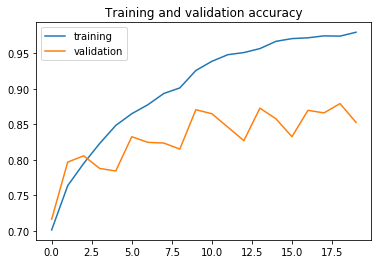

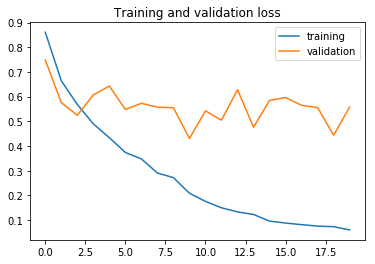

In [31]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')